In [1]:
import numpy as np
from matplotlib import pyplot as plt
from depth_map import createMap

## Make disparity map

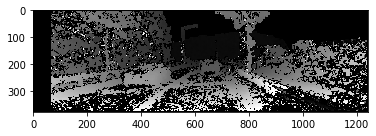

In [2]:
path_to_kitti = "KITTI/data_scene_flow/testing/"
disparity = createMap(path_to_kitti,'000183_11.png')
plt.imshow(disparity, 'gray');

In [3]:
LOOKBACK_WINDOW=10
FRAME = 183
uvd = np.array([[-16,-16,-16]]) # needed something to start, -16 will get chopped anyways
for lb in range(LOOKBACK_WINDOW):
    d = createMap(path_to_kitti,f'000{FRAME-lb}_11.png')
    u = np.tile(range(d.shape[1]), d.shape[0])
    v = np.repeat(range(d.shape[0]), d.shape[1])
    uv_disp = np.array([u,v,d.flatten()]).T
    uvd = np.concatenate((uvd, uv_disp))

In [4]:
print(uvd.shape)
uvd

(4616361, 3)


array([[ -16,  -16,  -16],
       [   0,    0,  -16],
       [   1,    0,  -16],
       ...,
       [1235,  373,  -16],
       [1236,  373,  -16],
       [1237,  373,  -16]])

## Remove -16 (no data) pixels

In [5]:
uvd_noblanks = uvd[uvd[:,2]!=-16]
uvd_noblanks

array([[  69,    4,  422],
       [  70,    4,  422],
       [  73,    4,  419],
       ...,
       [1187,  369,   36],
       [1188,  369,   37],
       [1189,  369,   38]])

## Plot

### U (horizontal scan)

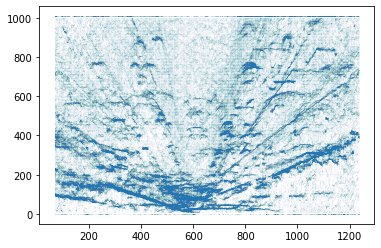

In [6]:
plt.scatter(x=uvd_noblanks[:,0],y=uvd_noblanks[:,2], s=0.00001);

### V (vertical scan)

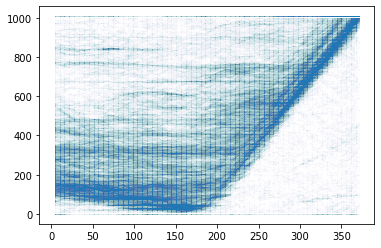

In [7]:
plt.scatter(x=uvd_noblanks[:,1],y=uvd_noblanks[:,2], s=0.00001);

## Fit

In [8]:
from sklearn.linear_model import RANSACRegressor

In [9]:
u = uvd_noblanks[:,0].reshape(-1, 1)
v = uvd_noblanks[:,1].reshape(-1, 1)
d = uvd_noblanks[:,2]

### U

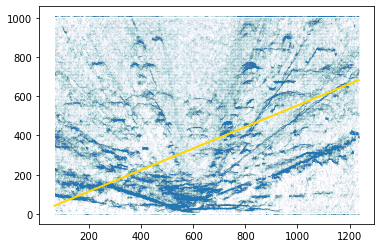

In [10]:
ransac_u = RANSACRegressor()
ransac_u.fit(u,d)
line_u = np.arange(u.min(), u.max())[:, np.newaxis]
line_du = ransac_u.predict(line_u)
plt.scatter(x=u,y=d,s=0.00001)
plt.plot(line_u, line_du, color='gold',linewidth=2,label="Ransac regressor");

### V

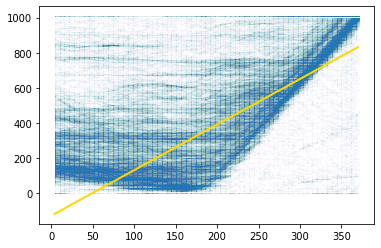

In [11]:
ransac_v = RANSACRegressor()
ransac_v.fit(v,d)
line_v = np.arange(v.min(), v.max())[:, np.newaxis]
line_dv = ransac_v.predict(line_v)
plt.scatter(x=v,y=d,s=0.00001)
plt.plot(line_v, line_dv, color='gold',linewidth=2,label="Ransac regressor");

In [12]:
# deal with the elbow
uvd_cut = uvd_noblanks[uvd_noblanks[:,1]>175]

In [13]:
v = uvd_cut[:,1].reshape(-1, 1)
d = uvd_cut[:,2]

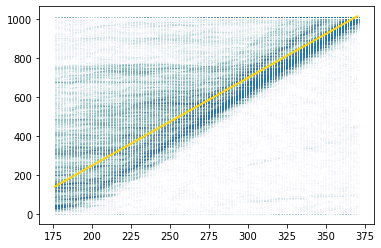

In [15]:
ransac_v = RANSACRegressor()
ransac_v.fit(v,d)
line_v = np.arange(v.min(), v.max())[:, np.newaxis]
line_dv = ransac_v.predict(line_v)
plt.scatter(x=v,y=d,s=0.00001)
plt.plot(line_v, line_dv, color='gold',linewidth=2,label="Ransac regressor");